# Data Scientist Professional Practical Exam

### Company Background

Nearly New Nautical is a website that allows users to advertise their used boats for sale. When users list their boat, they have to provide a range of information about their boat. Boats that get lots of views bring more traffic to the website, and more potential customers. 

To boost traffic to the website, the product manager wants to prevent listing boats that do not receive many views.




### Customer Question

The product manager wants to know the following:
- Can you predict the number of views a listing will receive based on the boat's features?



### Success Criteria

The product manager would consider using your model if, on average, the predictions were only 50% off of the true number of views a listing would receive.


### Dataset

The data you will use for this analysis can be accessed here: `"data/boat_data.csv"`

## Approach

1. Explore and assess the dataset
2. Clean the dataset and augment data where feasible
3. Perform analysis on the data and visualising the relationship between the predictors and label
4. Build and evaluate a machine learning model to predict the target label

## Data Validation

The dataset has 9888 rows and 10 columns with missing values before cleaning.
- `Price`: Boat price listed in different currencies on the website (character), converted the prices to a standard currency - USD and converted to numeric data type.
- `Boat Type`: Type of the boat (character), 126 initial boat types, consolidated to 26 boat types. 
- `Manufacturer`: Manufacturer of the boat (character), with 1338 missing values, replaced missing values with the most occurring manufacture for each boat type, 910 initial manufacturers, consolidated to 19 manufacturers. 
- `Type`: Condition of the boat and engine type (character), replaced the column with two columns - `Boat Condition` and `Engine Type`, replaced missing values with mode of each by boat type, 4 Boat Condition and 7 Engine Type entries.
- `Year Built`: Year of the boat built (numeric), 551 rows with the value 0 for year, replaced 0 with mode of year by Boat Condition.
- `Length`: Length in meter of the boat (numeric), 9 missing values, replaced missing values with mean of length by boat type.
- `Width`: Width in meter of the boat (numeric), 56 missing values, replaced missing values with mean of width by boat type.
- `Material`: Material of the boat (character), 1749 missing values, replaced missing values with mode of material by boat type.
- `Location`: Location of the boat is listed (character), 36 missing values, replaced missing values with mode of location by boat type, 2995 initial locations, consolidated to 10 locations.
- `Number of views last 7 days`: Number of views of the list last 7 days (numeric, target label), renamed to `Views`

Also engineered a new feature:
- `Age`: The age of the boat (current year - Year Built, numeric)

After the data validation, the dataset contains **9888 rows and 12 columns**

### Data Processing

In [1]:
# Use this cell to begin, and add as many cells as you need to complete your analysis!
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import missingno as msno
from collections import Counter
from datetime import date
import dataframe_image as dfi 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score, explained_variance_score
import catboost as cb

plt.style.use('ggplot')
%matplotlib inline

In [2]:
boat_data = pd.read_csv('data/boat_data.csv')
print(boat_data.shape)

(9888, 10)


In [3]:
boat_data.head()

Price            Boat Type          Manufacturer                 Type  \
0   CHF 3337          Motor Yacht  Rigiflex power boats  new boat from stock   
1   EUR 3490  Center console boat     Terhi power boats  new boat from stock   
2   CHF 3770           Sport Boat    Marine power boats  new boat from stock   
3  DKK 25900           Sport Boat    Pioner power boats  new boat from stock   
4   EUR 3399         Fishing Boat    Linder power boats  new boat from stock   

   Year Built  Length  Width       Material  \
0        2017    4.00   1.90            NaN   
1        2020    4.00   1.50  Thermoplastic   
2           0    3.69   1.42      Aluminium   
3        2020    3.00   1.00            NaN   
4        2019    3.55   1.46      Aluminium   

                                     Location  Number of views last 7 days  
0      Switzerland Â» Lake Geneva Â» VÃ©senaz                          226  
1                    Germany Â» BÃ¶nningstedt                           75  
2  Switzerland Â» Lake of Zurich Â» StÃ¤fa ZH                          124  
3                        Denmark Â» Svendborg                           64  
4               Germany Â» Bayern Â» MÃ¼nchen                           58

In [4]:
boat_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9888 entries, 0 to 9887
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Price                        9888 non-null   object 
 1   Boat Type                    9888 non-null   object 
 2   Manufacturer                 8550 non-null   object 
 3   Type                         9882 non-null   object 
 4   Year Built                   9888 non-null   int64  
 5   Length                       9879 non-null   float64
 6   Width                        9832 non-null   float64
 7   Material                     8139 non-null   object 
 8   Location                     9852 non-null   object 
 9   Number of views last 7 days  9888 non-null   int64  
dtypes: float64(2), int64(2), object(6)
memory usage: 772.6+ KB


In [5]:
boat_data.describe()

Year Built       Length        Width  Number of views last 7 days
count  9888.000000  9879.000000  9832.000000                  9888.000000
mean   1893.192860    11.570017     3.520124                   149.160801
std     460.201582     6.002820     1.220534                   151.819752
min       0.000000     1.040000     0.010000                    13.000000
25%    1996.000000     7.470000     2.540000                    70.000000
50%    2007.000000    10.280000     3.330000                   108.000000
75%    2017.000000    13.930000     4.250000                   172.000000
max    2021.000000   100.000000    25.160000                  3263.000000

In [6]:
boat_data.isna().sum() 

Price                             0
Boat Type                         0
Manufacturer                   1338
Type                              6
Year Built                        0
Length                            9
Width                            56
Material                       1749
Location                         36
Number of views last 7 days       0
dtype: int64

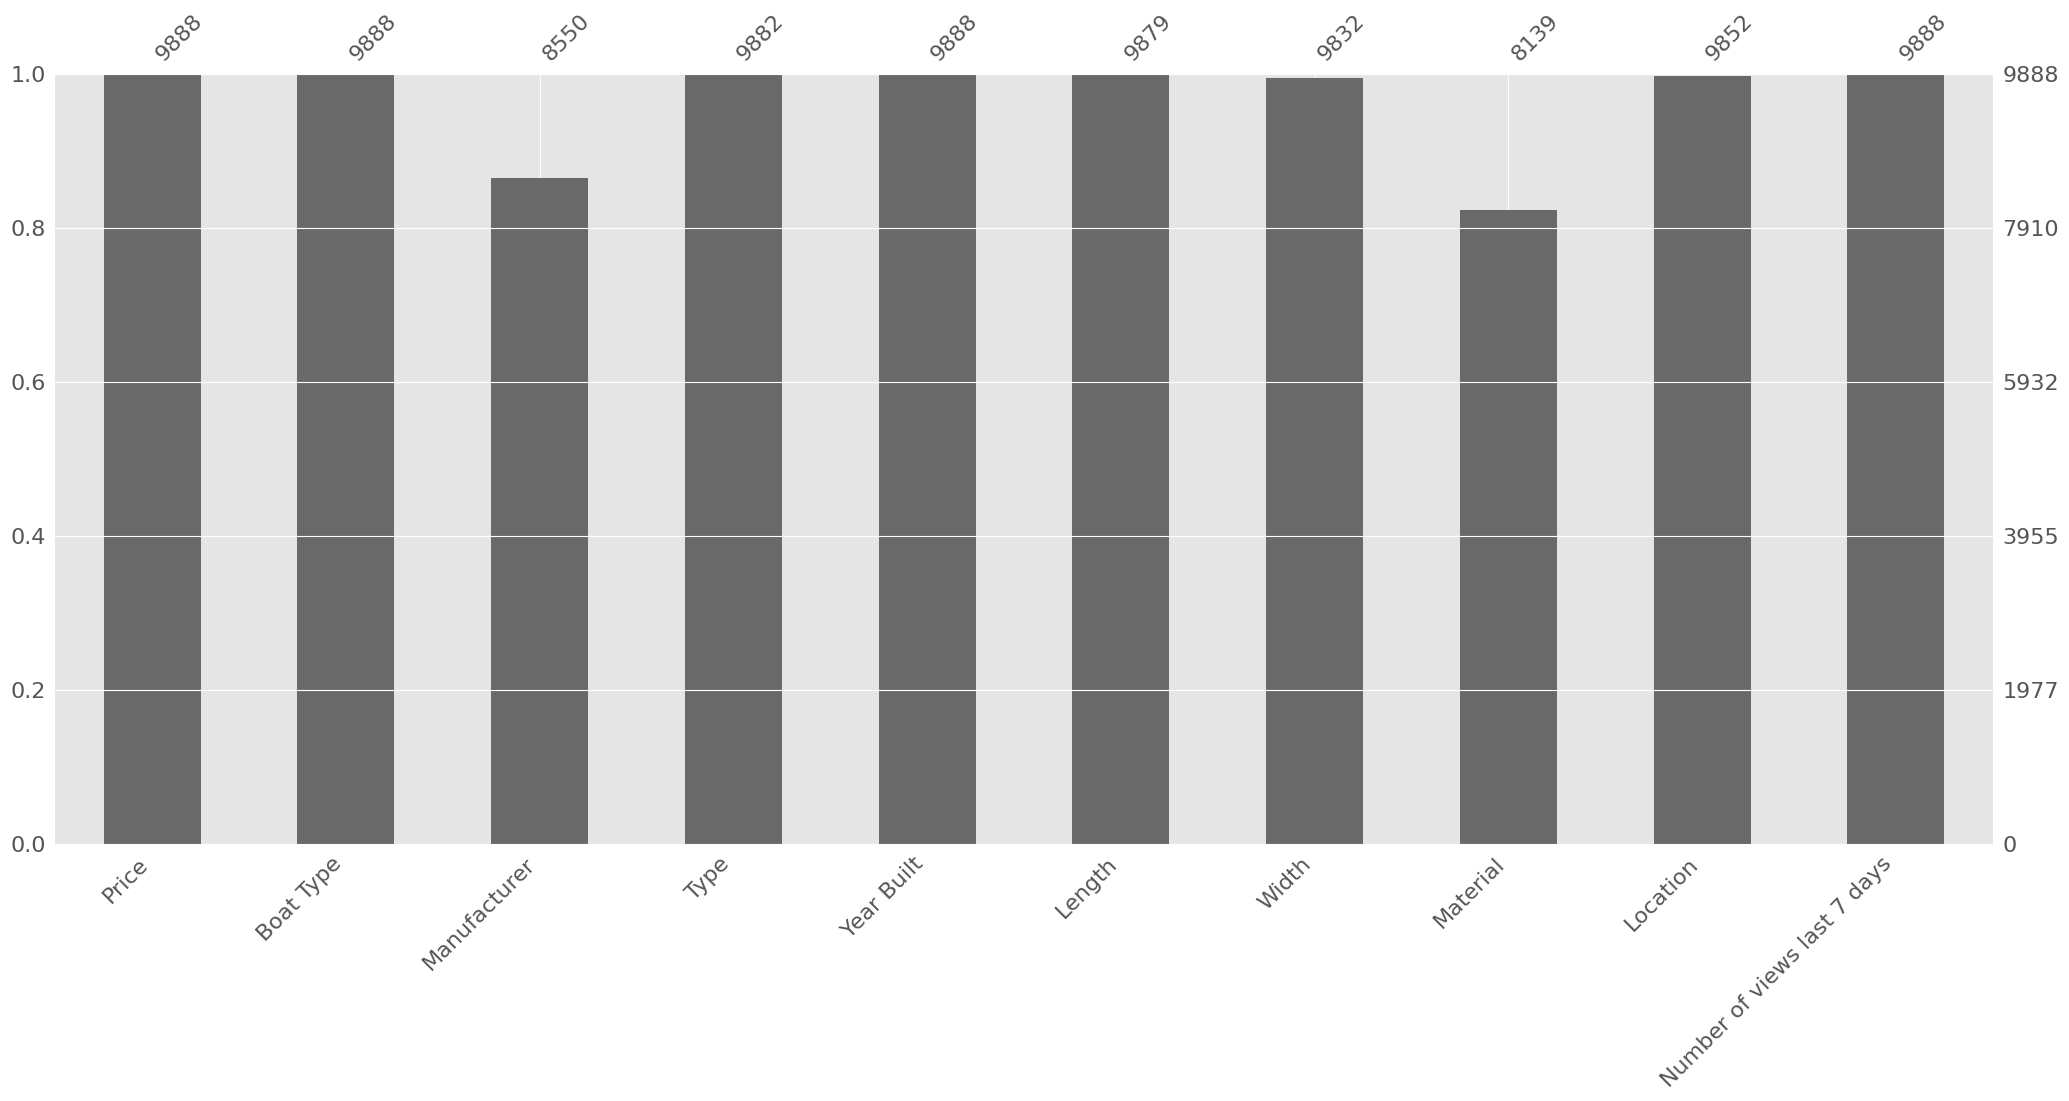

In [7]:
msno.bar(boat_data)
plt.savefig('images/missing_values_dist.jpeg')
plt.show()

In [8]:
percent_missing = (1 - (len(boat_data.dropna()) / len(boat_data))) * 100
print("{} % of the dataset is missing".format(round(percent_missing)))

29 % of the dataset is missing


There are some observations from the data information:
* 6 columns have missing data
* The 'Price' column is of type object, due to different currencies. We need to convert this to a standard currency
* The 'Year' column has a minimum value of 0, with 551 rows having 0 as the year. This can indicate missing values
* 29% of the total dataset is missing. Dropping this many missing rows might affect model performance. We'll try to clean the dataset

From careful inspection, the `Boat Type` column has instances where an observation has one or more boat types, i.e *'Motor Yacht, Sport Boat, Fishing Boat'* etc., giving rise to lots of boat types.

We will normalise this to only pick and reflect the first major boat type in the string, thereby reducing the different entries of boat types to a more unique and uniform boat type.

In [9]:
boat_data['Boat Type'] = boat_data['Boat Type'].str.strip().str.split(',').str[0]

In [10]:
boat_data.Manufacturer.value_counts(dropna=False)[:10]

NaN                       1338
BÃ©nÃ©teau power boats     631
Jeanneau power boats       537
Sunseeker power boats      383
Princess power boats       241
Sea Ray power boats        239
Cranchi power boats        219
Azimut power boats         215
Bavaria power boats        185
Fairline power boats       172
Name: Manufacturer, dtype: int64

The 'Manufacturer' column has the name of the companies with the suffixes 'power boats'. This can be cleaned by stripping this part away. There are also 1,338 missing values.

In [11]:
boat_data['Manufacturer'] = boat_data.Manufacturer.str.removesuffix(' power boats')

In [12]:
def fill_col_by_boat_type(df, col, col_by, numeric=False):
    """
    Helper function to fill columns with missing values by getting
    the mode or mean of each non-missing value by a non-null column.
    """
    
    temp_df = df[~df[col].isna()]
    
    if numeric:
        top_col_by_boat = temp_df.groupby(col_by)[col].mean().to_frame().dropna()
    else:
        top_col_by_boat = temp_df.groupby(col_by)[col].agg(lambda x: stats.mode(x)[0][0]).to_frame().dropna()
        
    col_boat_dict = dict(zip(top_col_by_boat.index, top_col_by_boat[col]))
    df[col] = df[col].fillna(df[col_by].map(col_boat_dict))
    
    df[col] = np.where(df[col].isna(), 'Others', df[col])
        
    return df

In [13]:
fill_col_by_boat_type(boat_data, 'Manufacturer', 'Boat Type')

Price            Boat Type Manufacturer  \
0      CHF 3337          Motor Yacht     Rigiflex   
1      EUR 3490  Center console boat        Terhi   
2      CHF 3770           Sport Boat       Marine   
3     DKK 25900           Sport Boat       Pioner   
4      EUR 3399         Fishing Boat       Linder   
...         ...                  ...          ...   
9883   CHF 4900           Sport Boat      Sea Ray   
9884   EUR 4516           Sport Boat      Sea Ray   
9885   EUR 4499           Sport Boat    BlueCraft   
9886   EUR 4300         Pontoon Boat        Whaly   
9887   CHF 3780         Fishing Boat      DarekCo   

                              Type  Year Built  Length  Width       Material  \
0              new boat from stock        2017    4.00   1.90            NaN   
1              new boat from stock        2020    4.00   1.50  Thermoplastic   
2              new boat from stock           0    3.69   1.42      Aluminium   
3              new boat from stock        2020    3.00   1.00            NaN   
4              new boat from stock        2019    3.55   1.46      Aluminium   
...                            ...         ...     ...    ...            ...   
9883            Used boat,Unleaded        1987    6.30   2.44            NaN   
9884           new boat from stock           0    4.17   1.68            GRP   
9885  new boat from stock,Unleaded        2020    4.40   1.80            GRP   
9886           new boat from stock        2018    4.37   1.89            NaN   
9887           new boat from stock        2019    3.60   1.60            GRP   

                                        Location  Number of views last 7 days  
0         Switzerland Â» Lake Geneva Â» VÃ©senaz                          226  
1                       Germany Â» BÃ¶nningstedt                           75  
2     Switzerland Â» Lake of Zurich Â» StÃ¤fa ZH                          124  
3                           Denmark Â» Svendborg                           64  
4                  Germany Â» Bayern Â» MÃ¼nchen                           58  
...                                          ...                          ...  
9883    Switzerland Â» Lago Maggiore Â» Riazzino                         1116  
9884               Germany Â» Hamburg Â» HAMBURG                           94  
9885     Germany Â» Nordrhein-Westfalen Â» Wesel                          354  
9886                       Italy Â» Dormelletto                           266  
9887        Switzerland Â» Brienzersee Â» Brienz                          194  

[9888 rows x 10 columns]

In [14]:
boat_data.Price.str.split(' ').str[0].unique()

array(['CHF', 'EUR', 'DKK', 'Â£'], dtype=object)

The 'Price' contains four unique currencies - Swiss Franc, Euros, Danish Krone and Pound Sterling. We will be converting these currencies to USD as the standard, using exchange rates from [Oanda Currency Converter](https://www.oanda.com/currency-converter/en/?from=EUR&to=USD&amount=1) as at 11th December, 2022.

In [15]:
def prices_usd(df):
    currencies = df.Price.str.split(' ').str[0].unique()
    usd_eqv = [1.06947, 1.05308, 0.14157, 1.22552]
    currency_dict = dict(zip(currencies, usd_eqv))
    
    df['Price_USD'] = df.Price.str.split(' ').str[1]
    df['Price_USD'] = df['Price_USD'].astype(float)
    df['Currencies'] = df.Price.str.split(' ').str[0]
    
    for key in currency_dict.keys():
        df['Price_USD'] = np.where(df['Currencies'] == key, round(df['Price_USD']*currency_dict[key]), df['Price_USD'])
    
    df.drop(['Price', 'Currencies'], axis=1, inplace=True)
    
    return df

In [16]:
prices_usd(boat_data)

Boat Type Manufacturer                          Type  \
0             Motor Yacht     Rigiflex           new boat from stock   
1     Center console boat        Terhi           new boat from stock   
2              Sport Boat       Marine           new boat from stock   
3              Sport Boat       Pioner           new boat from stock   
4            Fishing Boat       Linder           new boat from stock   
...                   ...          ...                           ...   
9883           Sport Boat      Sea Ray            Used boat,Unleaded   
9884           Sport Boat      Sea Ray           new boat from stock   
9885           Sport Boat    BlueCraft  new boat from stock,Unleaded   
9886         Pontoon Boat        Whaly           new boat from stock   
9887         Fishing Boat      DarekCo           new boat from stock   

      Year Built  Length  Width       Material  \
0           2017    4.00   1.90            NaN   
1           2020    4.00   1.50  Thermoplastic   
2              0    3.69   1.42      Aluminium   
3           2020    3.00   1.00            NaN   
4           2019    3.55   1.46      Aluminium   
...          ...     ...    ...            ...   
9883        1987    6.30   2.44            NaN   
9884           0    4.17   1.68            GRP   
9885        2020    4.40   1.80            GRP   
9886        2018    4.37   1.89            NaN   
9887        2019    3.60   1.60            GRP   

                                        Location  Number of views last 7 days  \
0         Switzerland Â» Lake Geneva Â» VÃ©senaz                          226   
1                       Germany Â» BÃ¶nningstedt                           75   
2     Switzerland Â» Lake of Zurich Â» StÃ¤fa ZH                          124   
3                           Denmark Â» Svendborg                           64   
4                  Germany Â» Bayern Â» MÃ¼nchen                           58   
...                                          ...                          ...   
9883    Switzerland Â» Lago Maggiore Â» Riazzino                         1116   
9884               Germany Â» Hamburg Â» HAMBURG                           94   
9885     Germany Â» Nordrhein-Westfalen Â» Wesel                          354   
9886                       Italy Â» Dormelletto                           266   
9887        Switzerland Â» Brienzersee Â» Brienz                          194   

      Price_USD  
0        3569.0  
1        3675.0  
2        4032.0  
3        3667.0  
4        3579.0  
...         ...  
9883     5240.0  
9884     4756.0  
9885     4738.0  
9886     4528.0  
9887     4043.0  

[9888 rows x 10 columns]

In [17]:
# normalize the Location column by splitting the string and getting its first value
boat_data['Location'] = boat_data['Location'].str.split(' Â» ', expand=True)[0]

In [18]:
boat_data.Type.value_counts(dropna=False)

Used boat,Diesel                4140
Used boat,Unleaded              1686
Used boat                       1462
new boat from stock,Unleaded    1107
new boat from stock              665
new boat from stock,Diesel       291
new boat on order,Unleaded       150
Display Model,Unleaded            75
new boat on order                 61
new boat on order,Diesel          61
Diesel                            57
Used boat,Electric                27
Unleaded                          22
Display Model,Diesel              19
new boat from stock,Electric      18
Display Model                     18
Used boat,Gas                     10
NaN                                6
Display Model,Electric             6
new boat from stock,Gas            2
new boat from stock,Hybrid         1
Used boat,Hybrid                   1
Display Model,Gas                  1
Electric                           1
Used boat,Propane                  1
Name: Type, dtype: int64

From the above output, the 'Type' column is an amalgation of the boat's condition and engine type. We can split this into different columns

In [19]:
boat_data[['Boat Condition', 'Engine Type']] = boat_data.Type.str.split(',', expand=True)
boat_data.drop('Type', axis=1, inplace=True)

In [20]:
boat_data['Boat Condition'].value_counts()

Used boat              7327
new boat from stock    2084
new boat on order       272
Display Model           119
Diesel                   57
Unleaded                 22
Electric                  1
Name: Boat Condition, dtype: int64

In [21]:
boat_data['Engine Type'].value_counts()

Diesel      4511
Unleaded    3018
Electric      51
Gas           13
Hybrid         2
Propane        1
Name: Engine Type, dtype: int64

In [22]:
engine_type = ['Diesel', 'Unleaded', 'Electric']

boat_data['Engine Type'] = np.where((boat_data['Boat Condition'].isin(engine_type) & boat_data['Engine Type'].isna()), 
                                    boat_data['Boat Condition'], boat_data['Engine Type'])
boat_data['Boat Condition'] = np.where((boat_data['Boat Condition'] == boat_data['Engine Type']), np.nan, 
                                       boat_data['Boat Condition'])

In [23]:
boat_data['Boat Condition'].value_counts()

Used boat              7327
new boat from stock    2084
new boat on order       272
Display Model           119
Name: Boat Condition, dtype: int64

In [24]:
boat_data['Engine Type'].value_counts()

Diesel      4568
Unleaded    3040
Electric      52
Gas           13
Hybrid         2
Propane        1
Name: Engine Type, dtype: int64

In [25]:
fill_col_by_boat_type(boat_data, 'Engine Type', 'Boat Type')
fill_col_by_boat_type(boat_data, 'Material', 'Boat Type')
fill_col_by_boat_type(boat_data, 'Location', 'Boat Type')
fill_col_by_boat_type(boat_data, 'Width', 'Boat Type', numeric=True)
fill_col_by_boat_type(boat_data, 'Length', 'Boat Type', numeric=True)
fill_col_by_boat_type(boat_data, 'Boat Condition', 'Boat Type')

Boat Type Manufacturer  Year Built Length Width  \
0             Motor Yacht     Rigiflex        2017    4.0   1.9   
1     Center console boat        Terhi        2020    4.0   1.5   
2              Sport Boat       Marine           0   3.69  1.42   
3              Sport Boat       Pioner        2020    3.0   1.0   
4            Fishing Boat       Linder        2019   3.55  1.46   
...                   ...          ...         ...    ...   ...   
9883           Sport Boat      Sea Ray        1987    6.3  2.44   
9884           Sport Boat      Sea Ray           0   4.17  1.68   
9885           Sport Boat    BlueCraft        2020    4.4   1.8   
9886         Pontoon Boat        Whaly        2018   4.37  1.89   
9887         Fishing Boat      DarekCo        2019    3.6   1.6   

           Material     Location  Number of views last 7 days  Price_USD  \
0               GRP  Switzerland                          226     3569.0   
1     Thermoplastic      Germany                           75     3675.0   
2         Aluminium  Switzerland                          124     4032.0   
3               GRP      Denmark                           64     3667.0   
4         Aluminium      Germany                           58     3579.0   
...             ...          ...                          ...        ...   
9883            GRP  Switzerland                         1116     5240.0   
9884            GRP      Germany                           94     4756.0   
9885            GRP      Germany                          354     4738.0   
9886            GRP        Italy                          266     4528.0   
9887            GRP  Switzerland                          194     4043.0   

           Boat Condition Engine Type  
0     new boat from stock      Diesel  
1     new boat from stock    Unleaded  
2     new boat from stock    Unleaded  
3     new boat from stock    Unleaded  
4     new boat from stock    Unleaded  
...                   ...         ...  
9883            Used boat    Unleaded  
9884  new boat from stock    Unleaded  
9885  new boat from stock    Unleaded  
9886  new boat from stock    Unleaded  
9887  new boat from stock    Unleaded  

[9888 rows x 11 columns]

In [26]:
boat_data.isna().sum()

Boat Type                      0
Manufacturer                   0
Year Built                     0
Length                         0
Width                          0
Material                       0
Location                       0
Number of views last 7 days    0
Price_USD                      0
Boat Condition                 0
Engine Type                    0
dtype: int64

We've been able to reduce the number of missing values in the `Manufacturer`, `Engine Type`, `Material`, `Location`, `Length`, `Width` and `Boat Condition` columns to 0.

In [27]:
# convert length and width back to float type, which was temporarily changed to type object when filling missing values

boat_data['Length'] = boat_data['Length'].astype(float)
boat_data['Width'] = boat_data['Width'].astype(float)

In [28]:
boat_data.rename(columns={'Number of views last 7 days': 'Views'}, inplace=True)

In the `Year Built` column, there are 551 observations with the value 0. This is impossible as there is no 0 year. To try not to skew the dataset by feeling with the mode of year, we will group the dataset by `Boat Condition` and find the mode of year for each boat condition and then replace the 0 values with the correct respective value

In [29]:
boat_data['Year Built'] = np.where(boat_data['Year Built']==0, np.nan, boat_data['Year Built'])

In [30]:
fill_col_by_boat_type(boat_data, 'Year Built', 'Boat Condition')
boat_data['Year Built'] = boat_data['Year Built'].astype(float).astype(int)

We're also going to engineer a new feature called `Age`, which will be the age of the boat

In [31]:
boat_data['Age'] = date.today().year - boat_data['Year Built']

In [32]:
boat_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9888 entries, 0 to 9887
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Boat Type       9888 non-null   object 
 1   Manufacturer    9888 non-null   object 
 2   Year Built      9888 non-null   int64  
 3   Length          9888 non-null   float64
 4   Width           9888 non-null   float64
 5   Material        9888 non-null   object 
 6   Location        9888 non-null   object 
 7   Views           9888 non-null   int64  
 8   Price_USD       9888 non-null   float64
 9   Boat Condition  9888 non-null   object 
 10  Engine Type     9888 non-null   object 
 11  Age             9888 non-null   int64  
dtypes: float64(3), int64(3), object(6)
memory usage: 927.1+ KB


In [33]:
boat_data.describe()

Year Built       Length        Width        Views     Price_USD  \
count  9888.000000  9888.000000  9888.000000  9888.000000  9.888000e+03   
mean   2005.649373    11.566696     3.519008   149.160801  3.190519e+05   
std      16.211830     6.001654     1.218518   151.819752  1.022390e+06   
min    1885.000000     1.040000     0.010000    13.000000  3.475000e+03   
25%    2000.000000     7.460000     2.540000    70.000000  4.528200e+04   
50%    2008.000000    10.270000     3.330000   108.000000  9.748600e+04   
75%    2018.000000    13.922500     4.250000   172.000000  2.622170e+05   
max    2021.000000   100.000000    25.160000  3263.000000  3.264548e+07   

               Age  
count  9888.000000  
mean     16.350627  
std      16.211830  
min       1.000000  
25%       4.000000  
50%      14.000000  
75%      22.000000  
max     137.000000

In [34]:
for col in boat_data.select_dtypes(include='object'):
    print('{} has {} entries \n'.format(col, boat_data[col].nunique()))

Boat Type has 26 entries 

Manufacturer has 911 entries 

Material has 12 entries 

Location has 122 entries 

Boat Condition has 4 entries 

Engine Type has 7 entries 



From the output above, we can see that `Manufacturer` and `Location` has high cardinality. As such, we will normalise the columns to have less unique values

In [35]:
def categorise(df, col, threshold):
    """
    Helper function that helps categorise less occuring values and 
    reduce the number of unique values.
    """
    
    threshold = int(threshold * len(df[col]))
    s, i = 0, 0
    categories_list=[]
    
    counts = Counter(df[col])
    
    while s < threshold and i < len(counts):
        s += counts[counts.most_common()[i][0]]
        categories_list.append(counts.most_common()[i][0])
        i += 1

    categories_list.append('Other')
 
    df[col] = df[col].apply(lambda x: x if x in categories_list else 'Other')
    
    return df

In [36]:
categorise(boat_data, 'Manufacturer', 0.5)
categorise(boat_data, 'Location', 0.9)

Boat Type Manufacturer  Year Built  Length  Width  \
0             Motor Yacht        Other        2017    4.00   1.90   
1     Center console boat        Other        2020    4.00   1.50   
2              Sport Boat        Other        2020    3.69   1.42   
3              Sport Boat        Other        2020    3.00   1.00   
4            Fishing Boat        Other        2019    3.55   1.46   
...                   ...          ...         ...     ...    ...   
9883           Sport Boat      Sea Ray        1987    6.30   2.44   
9884           Sport Boat      Sea Ray        2020    4.17   1.68   
9885           Sport Boat        Other        2020    4.40   1.80   
9886         Pontoon Boat        Other        2018    4.37   1.89   
9887         Fishing Boat        Other        2019    3.60   1.60   

           Material     Location  Views  Price_USD       Boat Condition  \
0               GRP  Switzerland    226     3569.0  new boat from stock   
1     Thermoplastic      Germany     75     3675.0  new boat from stock   
2         Aluminium  Switzerland    124     4032.0  new boat from stock   
3               GRP      Denmark     64     3667.0  new boat from stock   
4         Aluminium      Germany     58     3579.0  new boat from stock   
...             ...          ...    ...        ...                  ...   
9883            GRP  Switzerland   1116     5240.0            Used boat   
9884            GRP      Germany     94     4756.0  new boat from stock   
9885            GRP      Germany    354     4738.0  new boat from stock   
9886            GRP        Italy    266     4528.0  new boat from stock   
9887            GRP  Switzerland    194     4043.0  new boat from stock   

     Engine Type  Age  
0         Diesel    5  
1       Unleaded    2  
2       Unleaded    2  
3       Unleaded    2  
4       Unleaded    3  
...          ...  ...  
9883    Unleaded   35  
9884    Unleaded    2  
9885    Unleaded    2  
9886    Unleaded    4  
9887    Unleaded    3  

[9888 rows x 12 columns]

In [37]:
for col in boat_data.select_dtypes(include='object'):
    print('{} has {} entries \n'.format(col, boat_data[col].nunique()))

Boat Type has 26 entries 

Manufacturer has 19 entries 

Material has 12 entries 

Location has 10 entries 

Boat Condition has 4 entries 

Engine Type has 7 entries 



We've successfully cleaned our dataset with no missing values. This cleaned and augmented dataset will now be used for analysis and modeling.

### Exploratory Data Analysis

I have investigated the target variable and predictors of the boat listing, and the relationship between them. The dataset is rightly skewed.
Using a PairPlot, I was able to spot the relationship between Views and the numeric variables. There is linear relationship between Views and the numeric variables.

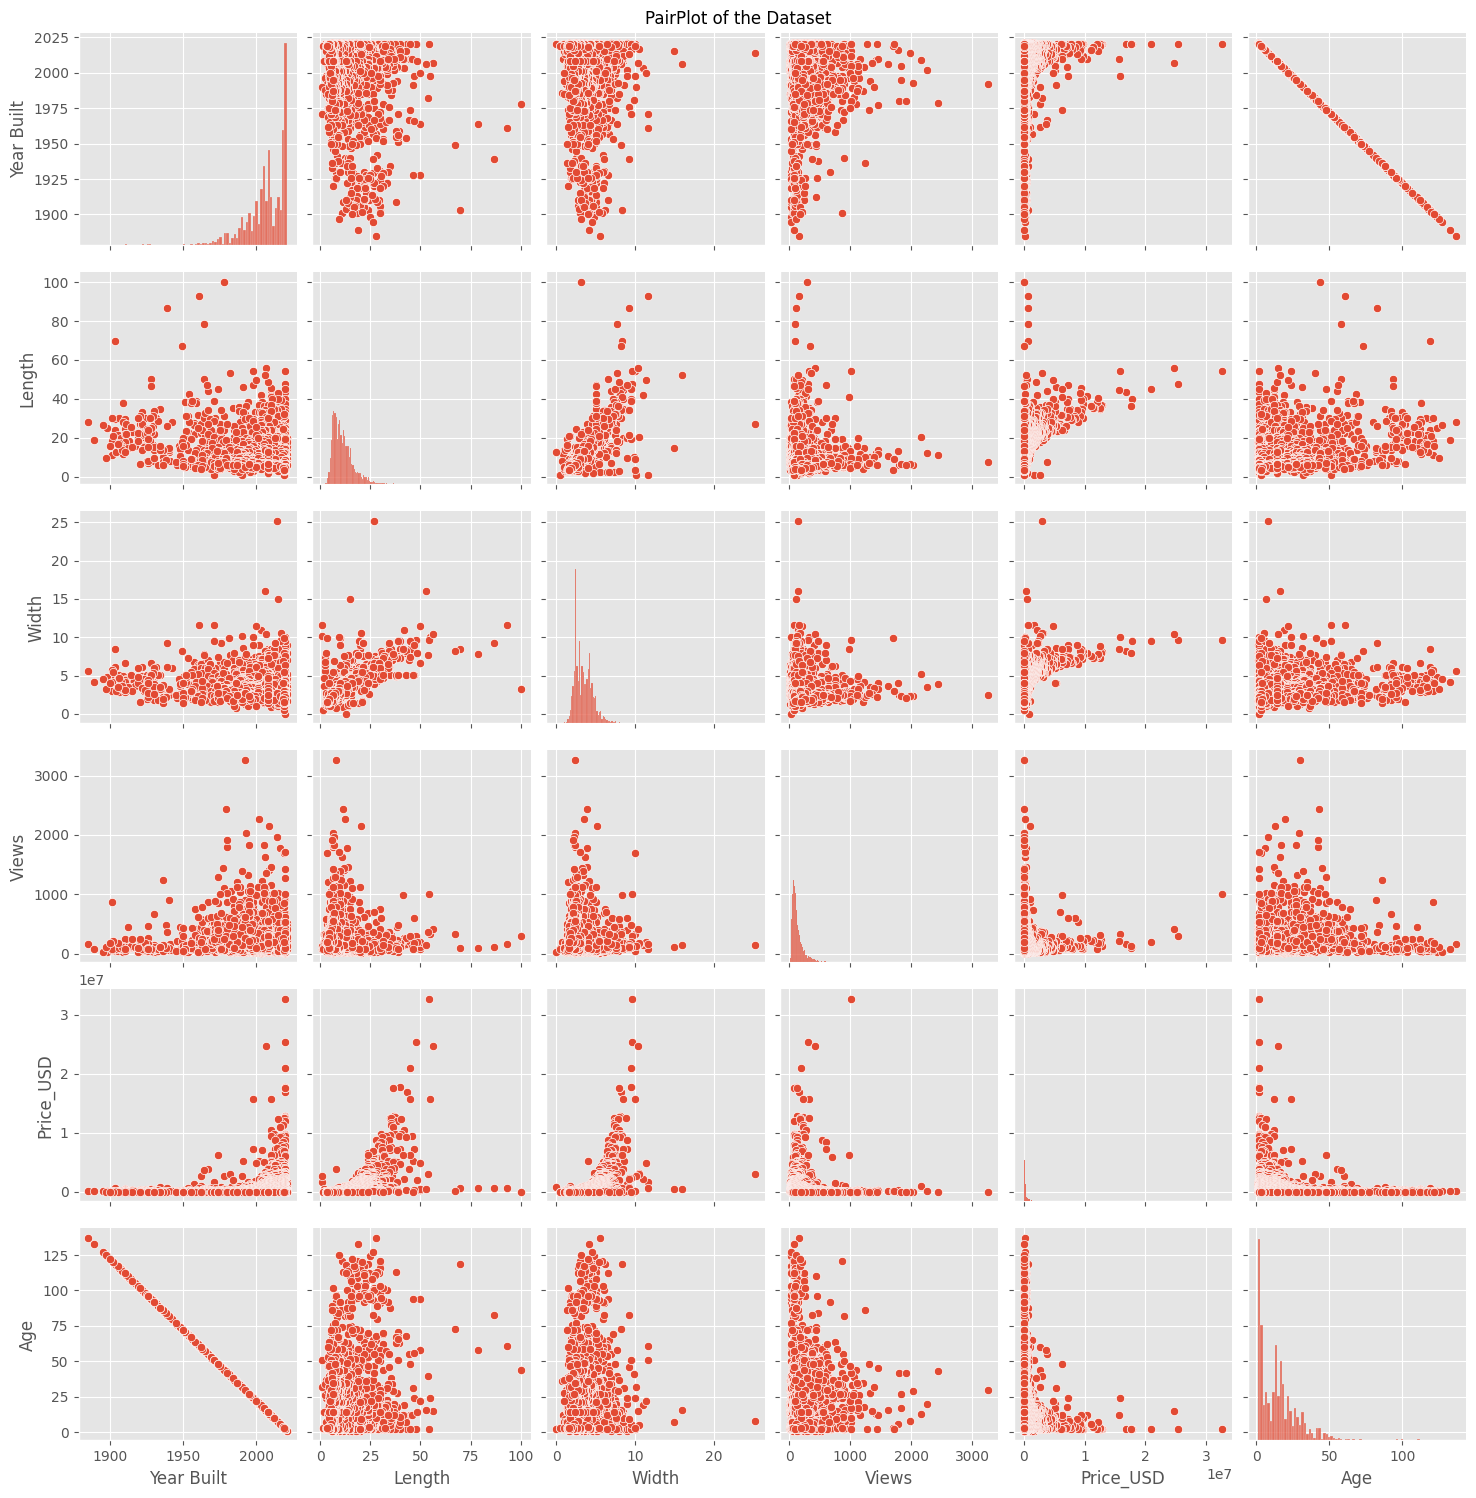

In [38]:
sns.pairplot(boat_data)
plt.suptitle('PairPlot of the Dataset', y=1)
plt.savefig('images/pairplot.jpeg')

#### Target Variable - Views

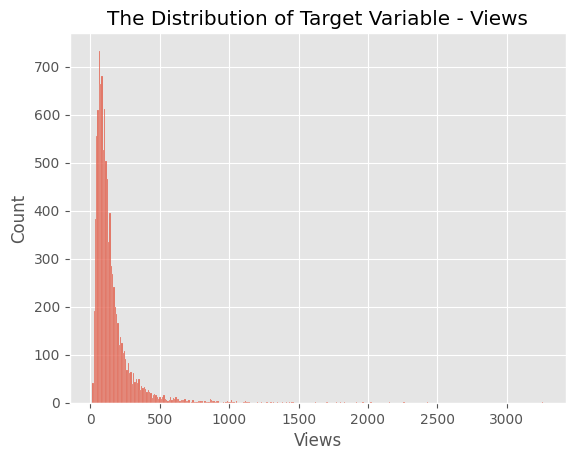

In [39]:
sns.histplot(boat_data['Views']).set(title='The Distribution of Target Variable - Views');

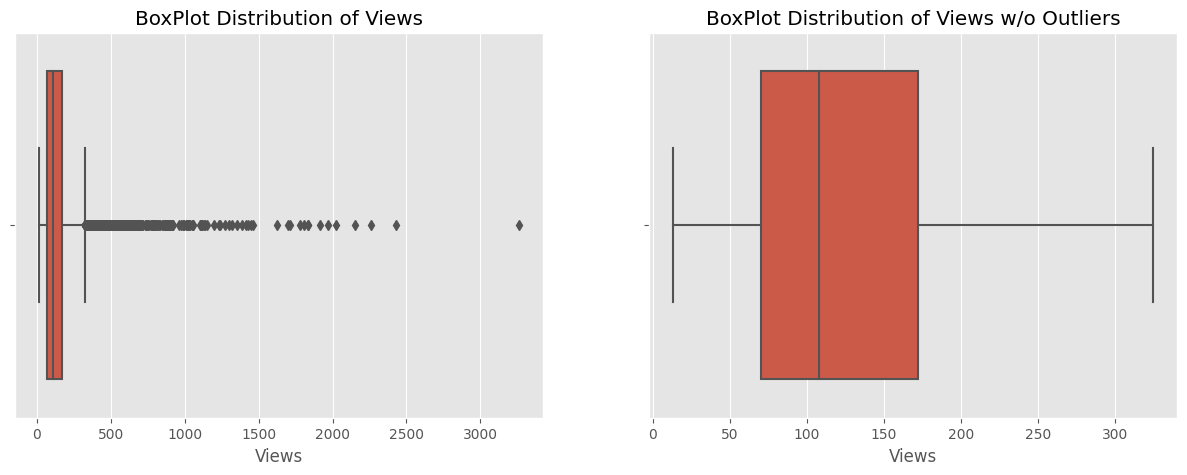

In [40]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.boxplot(data=boat_data, x='Views', ax=ax[0]).set(title='BoxPlot Distribution of Views')
sns.boxplot(data=boat_data, x='Views', showfliers=False, ax=ax[1]).set(title='BoxPlot Distribution of Views w/o Outliers')
plt.savefig('images/views_boxplot.jpeg');

From the chart distribution, the data is rightly skewed with a lot of outliers. The views of most boats on the website between 10 and 350 views

In [41]:
def filter_outliers(df, col):
    q1, q3= df[col].quantile([.25, .75])
    iqr = q3 - q1
    
    return df.query('(@q1 - 1.5 * @iqr) <= {} <= (@q3 + 1.5 * @iqr)'.format(col))

In [42]:
filtered_data = filter_outliers(boat_data, 'Views')

In [43]:
sns.histplot(filtered_data['Views']).set(title='The Distribution of Target Variable - Views');

#### Numeric Variables

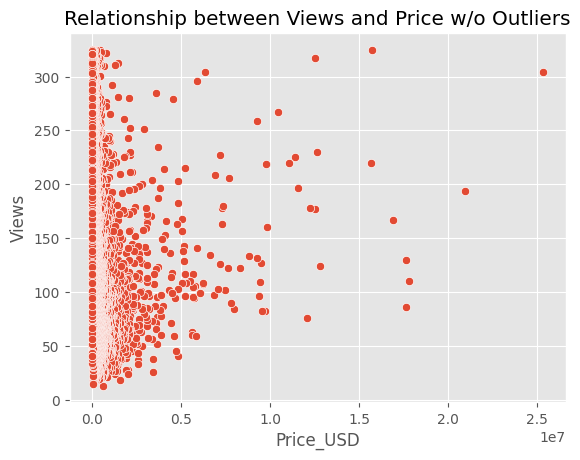

In [44]:
sns.scatterplot(data=filtered_data, y='Views', x='Price_USD')
plt.title('Relationship between Views and Price w/o Outliers')
plt.savefig('images/views_price.jpeg')

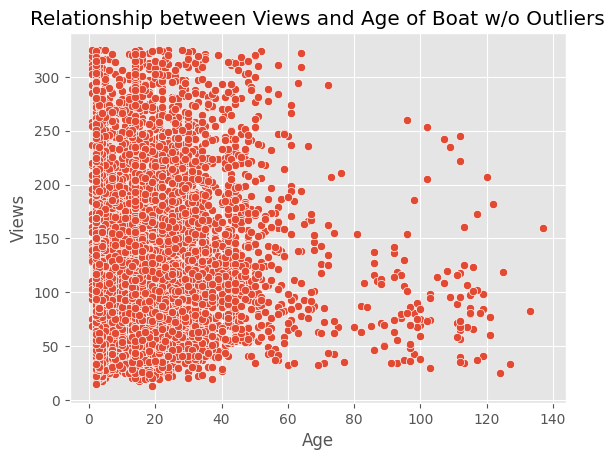

In [45]:
sns.scatterplot(data=filtered_data, y='Views', x='Age')
plt.title('Relationship between Views and Age of Boat w/o Outliers')
plt.savefig('images/views_age.jpeg')

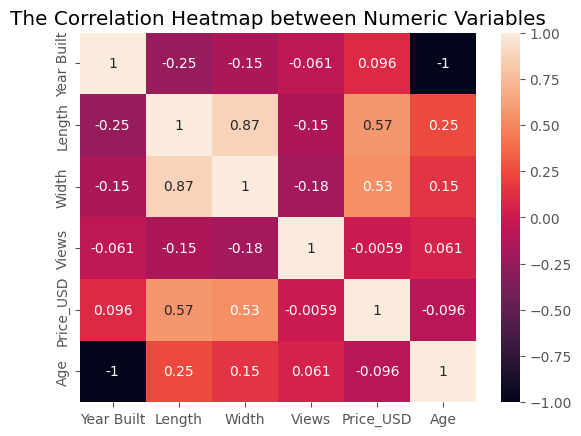

In [46]:
corr = filtered_data.corr()
sns.heatmap(corr, annot=True).set(title='The Correlation Heatmap between Numeric Variables')
plt.savefig('images/heatmap.jpeg')

There is little to negative correlations between `Views` and the other columns in the dataset

#### Categorical Variables

In [47]:
def plot_cat_cols(df, col, agg=None, combine=False):
    """
    Plot a bar plot showing the total and average number of views by a categorical column.
    
    Args:
    df: A Pandas DataFrame containing the data to plot.
    col: The name of the categorical column to plot.
    combine: A boolean indicating whether to plot the total and average views in a single plot (True) 
             or in separate plots (False).
    """
    if combine:
        aggregation_functions = {'Total Number of Views': 'sum', 'Average Number of Views': 'mean'}
        fig, axs = plt.subplots(2,1, figsize=(8, 10))
        
        # Loop through the aggregation functions and plot the data
        for i, (title, agg_func) in enumerate(aggregation_functions.items()):
            temp_df = df.groupby(col)['Views'].agg(agg_func).sort_values(ascending=False).reset_index().head(20)
            ax = axs[i]
            sns.barplot(data=temp_df, x='Views', y=col, order=temp_df[col], ax=ax)
            ax.set_title(title + ' by {}'.format(col))
            if agg_func == 'mean':
                ax.axvline(df['Views'].mean(), color='black', linestyle='--')
                ax.annotate('Average Number of Views', xy =(df['Views'].mean() + 10 , 4)) 
            plt.savefig('images/{}_views_by_{}.jpeg'.format(agg_func, col))
        

    else:
        # Use the specified aggregation function or default to 'sum'
        agg_func = agg if agg else 'sum'
        temp_df = df.groupby(col)['Views'].agg(agg_func).sort_values(ascending=False).reset_index().head(20)
        sns.barplot(data=temp_df, x='Views', y=col, order=temp_df[col])
         

        # Set the plot title based on the aggregation function
        if agg_func == 'sum':
            plt.title('Total Number of Views by {}'.format(col))
        elif agg_func == 'mean':
            plt.title('Average Number of Views by {}'.format(col))
            plt.axvline(df['Views'].mean(), color='black', linestyle='--')
            plt.annotate('Average Number of Views', xy =(df['Views'].mean() + 10 , 4))
        else:
            plt.title('{} of Views by {}'.format(agg_func.capitalize(), col))
            
        plt.savefig('images/{}_views_by_{}.jpeg'.format(agg_func, col))

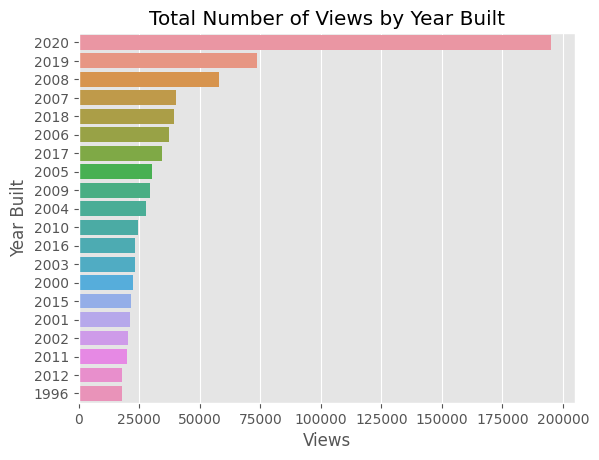

In [48]:
filtered_data['Year Built'] = filtered_data['Year Built'].astype('category')
plot_cat_cols(filtered_data, 'Year Built', agg='sum')

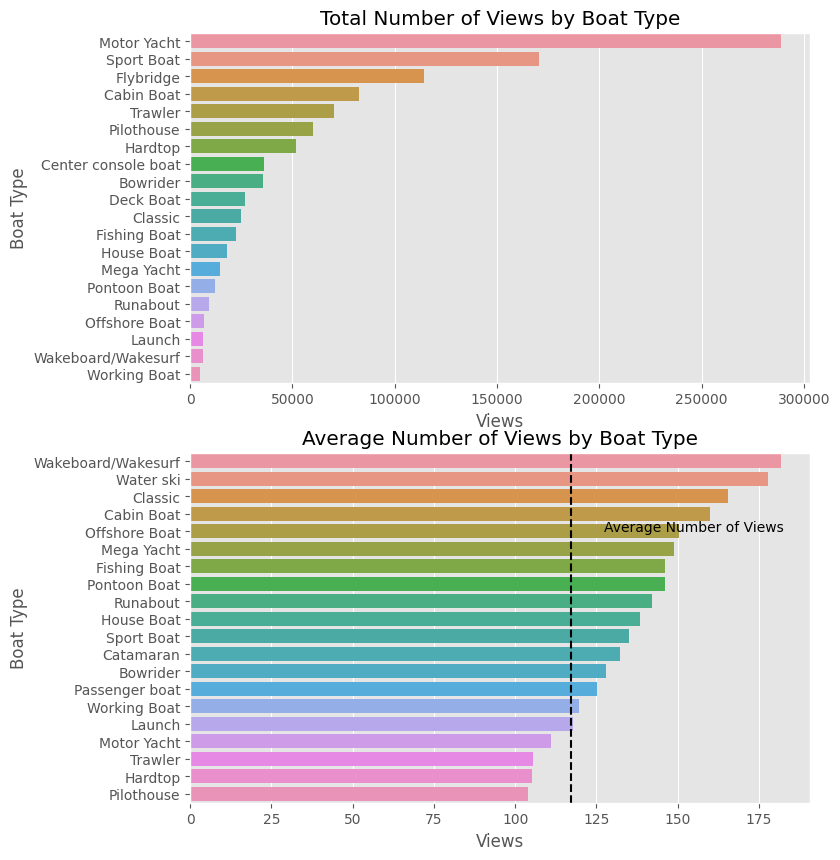

In [49]:
plot_cat_cols(filtered_data, 'Boat Type', combine=True)

In [50]:
plot_cat_cols(filtered_data, 'Manufacturer', combine=True)

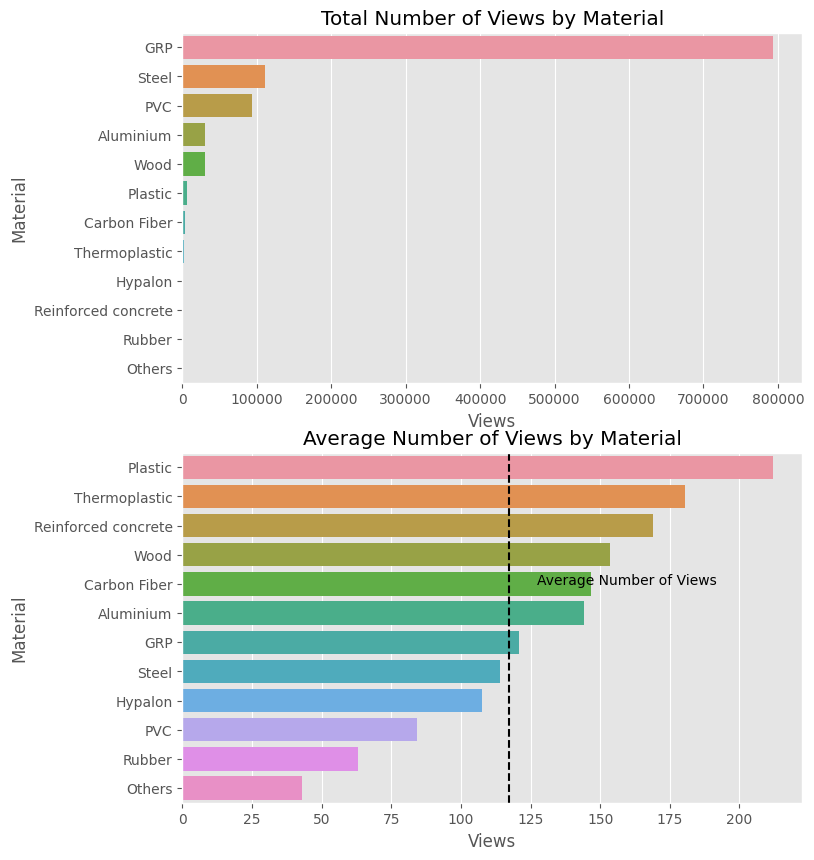

In [51]:
plot_cat_cols(filtered_data, 'Material', combine=True)

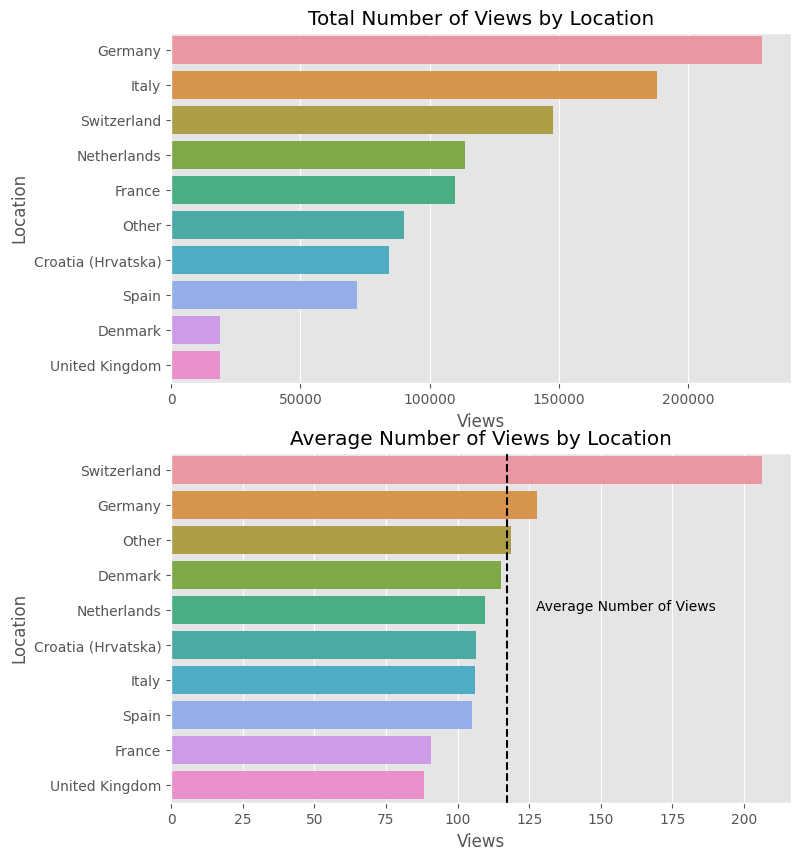

In [52]:
plot_cat_cols(filtered_data, 'Location', combine=True)

In [53]:
plot_cat_cols(filtered_data, 'Engine Type', combine=True)

In [54]:
plot_cat_cols(filtered_data, 'Boat Condition', combine=True)

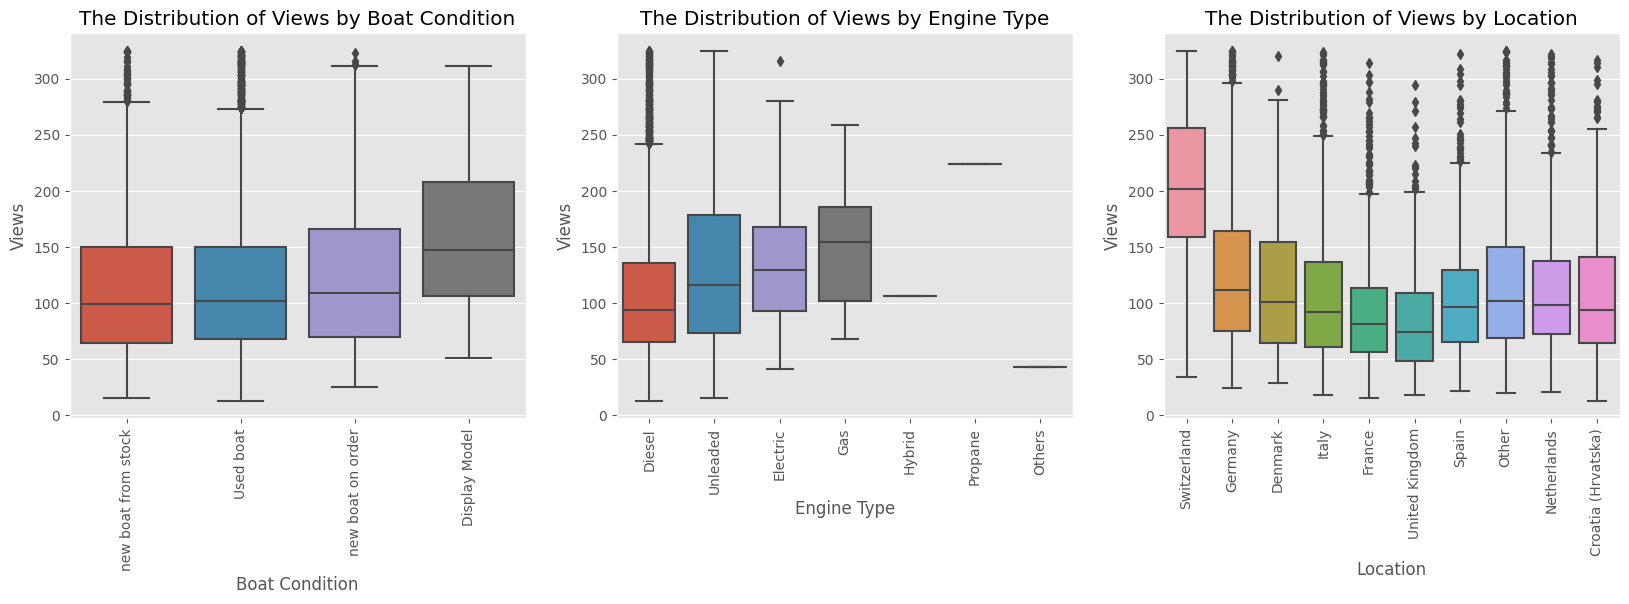

In [55]:
fig, axes = plt.subplots(1,3,figsize=(20,5))
sns.boxplot(data=filtered_data, x='Boat Condition',y='Views',ax=axes[0]).set(title='The Distribution of Views by Boat Condition')
sns.boxplot(data=filtered_data, x='Engine Type',y='Views',ax=axes[1]).set(title='The Distribution of Views by Engine Type')
sns.boxplot(data=filtered_data, x='Location',y='Views',ax=axes[2]).set(title='The Distribution of Views by Location')
for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=90)
    
plt.savefig('images/cat_boxplots.jpeg');

From the boxplots above, we can see that the difference in distribution of views among each categories isn't too high.

### Model Fitting & Evaluation

Since the target variable, Views, is a numerical variable, predicting the views is a regression task. For the model fitting, I am choosing the Linear Regression model as the baseline model. The comparison model I am choosing is the CatBoostRegressor model from the CatBoost library because it is better suited to handle dataset with categorical features, without encoding.

For the evaluation, I will be using Mean Absolute Percentage Error to evaluate the model as a loss function due to the product manager request. MAPE measures the prediction accuracy of our forecasting model.

##### Linear Regression Model

To enable modeling, we chose all columns except Views as features and Views as target variable. I also have made the following changes:
- Convert the categorical variables into numeric features
- Split the data into a training set and a test set

In [56]:
X_lr = boat_data.drop(['Views', 'Year Built'], axis=1)
y_lr = boat_data['Views']

In [57]:
le = LabelEncoder()
scaler = StandardScaler()
pca = PCA()

for col in X_lr.select_dtypes(include='object').columns:
    X_lr[col] = le.fit_transform(X_lr[col])

X_scaled = scaler.fit_transform(X_lr)
X_scaled = pca.fit_transform(X_scaled)

In [58]:
XS_train, XS_test, ys_train, ys_test = train_test_split(X_scaled, y_lr, test_size=.25, random_state=1234)

In [59]:
lr = LinearRegression()
lr.fit(XS_train, ys_train)

LinearRegression()

In [60]:
lr_pred = lr.predict(XS_test)

lr_r2 = round(r2_score(ys_test, lr_pred), 2)
lr_rmse = round(np.sqrt(mean_squared_error(ys_test, lr_pred)), 2)
lr_mape = round(mean_absolute_percentage_error(ys_test, lr_pred), 2)
print('Testing performance')
print('Linear Regression RMSE: {:.2f}'.format(lr_rmse))
print('Linear Regression MAPE: {:.2f}'.format(lr_mape))
print('Linear Regression R2: {:.2f}'.format(lr_r2))

Testing performance
Linear Regression RMSE: 129.70
Linear Regression MAPE: 0.80
Linear Regression R2: 0.17


##### CatBoostRegressor Model

In [61]:
X_cb = boat_data.drop(['Views', 'Year Built'], axis=1)
y_cb = boat_data['Views']

In [62]:
cat_cols = list(X_cb.select_dtypes(include=[object]).columns)

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X_cb, y_cb, test_size=.25, random_state=1234)

In [64]:
model = cb.CatBoostRegressor(loss_function='RMSE', learning_rate=0.05, 
                             l2_leaf_reg=2, depth=10, random_strength=2)


model.fit(X_train, y_train, cat_features=cat_cols, verbose=False)

In [65]:
cb_pred = model.predict(X_test)
cb_rmse = round(np.sqrt(mean_squared_error(y_test, cb_pred)), 2)
cb_r2 = round(r2_score(y_test, cb_pred), 2)
cb_mape = round(mean_absolute_percentage_error(y_test, cb_pred), 2)
print('Testing performance')
print('RMSE: {:.2f}'.format(cb_rmse))
print('MAPE: {:.2f}'.format(cb_mape))
print('R2: {:.2f}'.format(cb_r2))

Testing performance
RMSE: 111.46
MAPE: 0.50
R2: 0.39


#### Model Evaluation

In [66]:
eval_dict = {'model_name': ('LinearRegression', 'CatBoostRegressor'),
             'RMSE': (lr_rmse, cb_rmse),
             'MAPE': (lr_mape, cb_mape),
             'R2': (lr_r2, cb_r2)}

eval_df = pd.DataFrame(eval_dict)
eval_df = eval_df.set_index('model_name')

def df_style(val):
    return "font-weight: bold"

last_row = pd.IndexSlice[eval_df.index[eval_df.index == "CatBoostRegressor"], :]
eval_df_styled = eval_df.style.applymap(df_style, subset=last_row)
eval_df_styled

In [67]:
dfi.export(eval_df_styled, 'images/eval_df.png', table_conversion='matplotlib')

In [68]:
def plot_performance(y_true, y_pred, model):
    data_point = list(range(100))
    plt.figure(figsize=(12,8))
    plt.plot(data_point, y_true[0:100], color='g', label='True View Value')
    plt.plot(data_point, y_pred[0:100], color='r', label='Predicted View Value')
    plt.ylabel('Views')
    plt.legend()
    plt.title('{} Predicted Value and True Value for first 100 observations of Test Data'.format(model))
    plt.savefig('images/{}_model_performance.jpeg'.format(model))

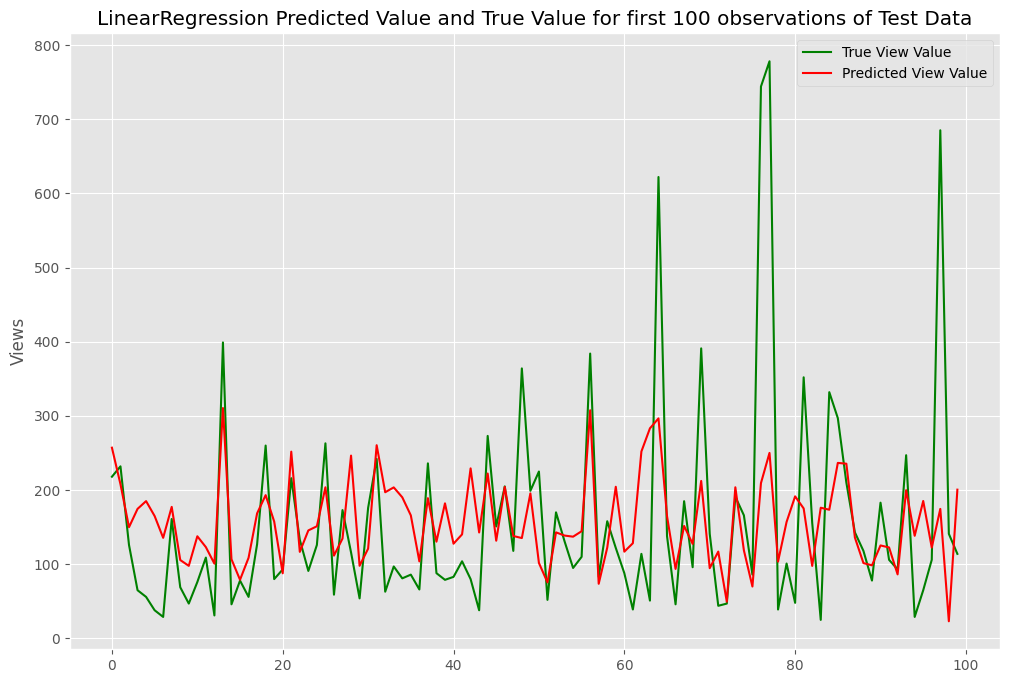

In [69]:
plot_performance(ys_test, lr_pred, 'LinearRegression')

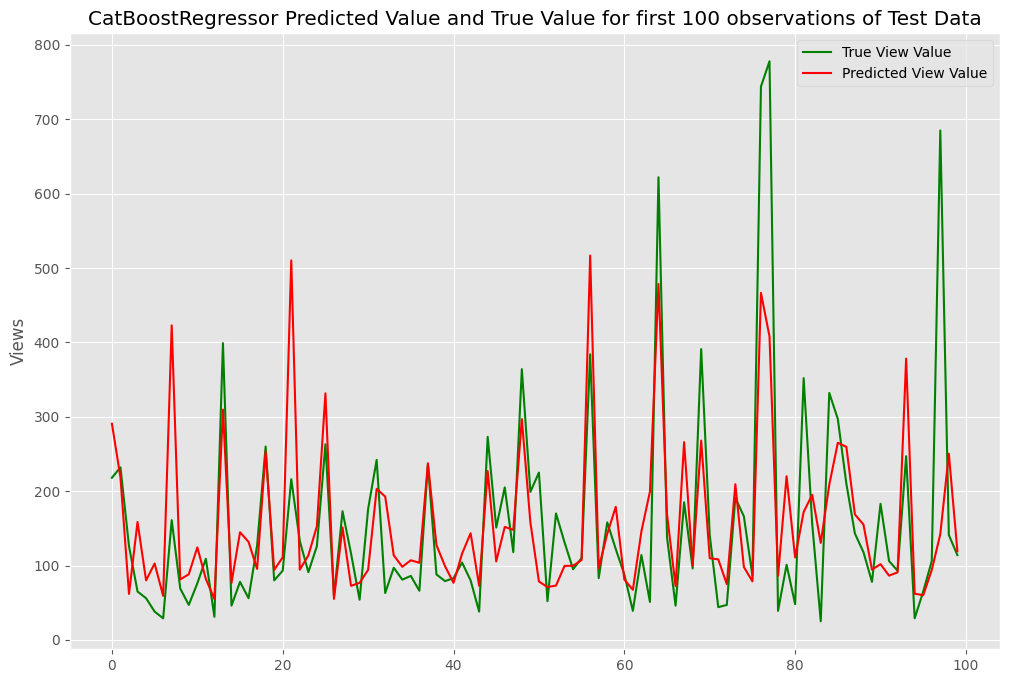

In [70]:
plot_performance(y_test, cb_pred, 'CatBoostRegressor')

##### Finding Feature Importance

**Linear Regression**

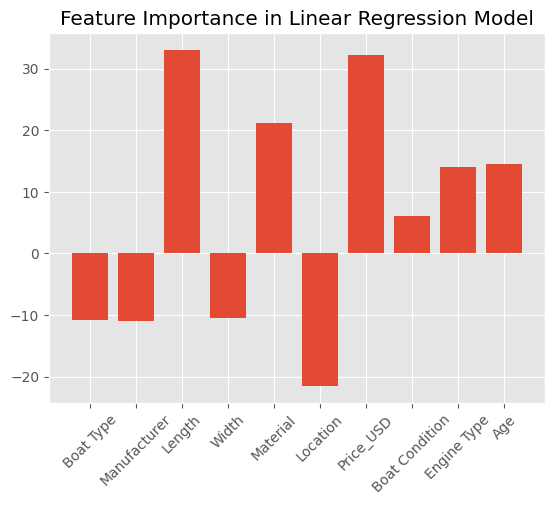

In [71]:
feature_cols = X_lr.columns.tolist()
resultdict = {}
for i in range(len(feature_cols)):
    resultdict[feature_cols[i]] = lr.coef_[i]
    
plt.bar(resultdict.keys(),resultdict.values())
plt.xticks(rotation=45)
plt.title('Feature Importance in Linear Regression Model')
plt.savefig('images/lr_feature_importance.jpeg')

**CatBoostRegressor**

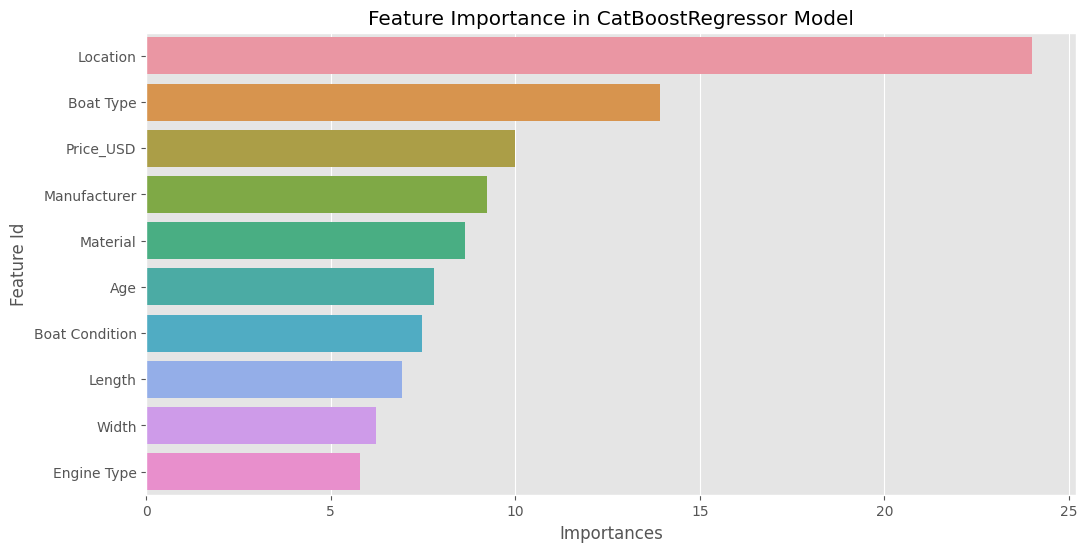

In [72]:
plt.figure(figsize=(12, 6))
ax = sns.barplot(x="Importances", y="Feature Id", data=model.get_feature_importance(prettified=True))
ax.set_title('Feature Importance in CatBoostRegressor Model')
plt.savefig('images/cb_feature_importance.jpeg')

### Results

The Mean Absolute Percentage Error of the Linear Regression and the CatBoostRegressor model is 0.8 and 0.5, meaning **the CatBoostRegressor model has less error in predicting number of views** i.e. it will, on average, predict wrong number of views 50% of the time.

The R squared of the Linear Regression and the CatBoostRegressor model is 0.17 and 0.39, meaning **the CatBoostRegressor model fits the features better** as 39% of the observed variation can be explained by the model's inputs.

`Location`, `Boat Type`, `Price` are the top three predictors that impact the CatBoostRegressor model's performance.

**Evaluate by Business Criteria**

The product manager would consider using the model if, on average, the predictions were only 50% off of the true number of views a listing would receive. With CatBoostRegressor having a MAPE value of 0.5, this passes the product manager's criteria.

### Recommendation

- Deploy the CatBoostRegressor model into production to help the product manager make better decisions.
- Location data can be changed to regions to have less unique values rather than country.
- The listing form can be validated to ensure that all fields are filled to reduce missing values, increasing the efficiency of the model and making better analysis.